In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")

from helper import load_countries, join_countries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DOMAIN_LOCALIZATION = True

DATA_PATH = "../../data/"

if DOMAIN_LOCALIZATION:
    counts_file = f"{DATA_PATH}from_cluster/mentions_counts_by_domain_state_and_days_filtered_5themes.csv"
else:
    counts_file = f"{DATA_PATH}from_cluster/mentions_counts_by_state_and_days_filtered_5themes.csv"

# Data loading and cleanup

We first load the file processed on the cluster that contain the counts of mentions for each days and countries and then join it with a the countries csv to get the real names and regions of them.

In [11]:
countries = load_countries(DATA_PATH+"assets/")
counts = pd.read_csv(counts_file)
counts.ENV_COUNT.fillna(0, inplace=True)
counts.dropna(inplace=True)
counts = join_countries(counts, countries, with_iso=True)
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.sample(10)

,GLOBAL_COUNT,ENV_COUNT,Country,Region,ISO,DATE,Ratio
78846,1220,30.0,Korea (Democratic People's Republic of),Asia,KP,2016-06-21,0.024590
23250,73,2.0,Brazil,Americas,BR,2015-09-09,0.027397
63930,12,0.0,Croatia,Europe,HR,2017-02-18,0.000000
36334,16,0.0,Cook Islands,Oceania,CK,2015-09-26,0.000000
135288,371,73.0,Trinidad and Tobago,Americas,TT,2017-09-21,0.196765
129931,16,0.0,Saint Lucia,Americas,LC,2017-07-19,0.000000
78457,231,0.0,Kyrgyzstan,Asia,KG,2015-10-14,0.000000
94039,51,0.0,Macedonia,Europe,MK,2017-07-17,0.000000
9623,70,5.0,Austria,Europe,AT,2015-04-15,0.071429
55353,10,0.0,Grenada,Americas,GD,2016-07-19,0.000000


In [12]:
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,1.619460e+05,161946.000000,161946.000000
mean,4.076587e+03,143.802805,0.033453
std,3.310930e+04,1377.374622,0.092291
min,1.000000e+00,0.000000,0.000000
25%,3.800000e+01,0.000000,0.000000
50%,1.670000e+02,1.000000,0.004808
75%,7.010000e+02,17.000000,0.030606
max,1.009617e+06,99521.000000,1.000000


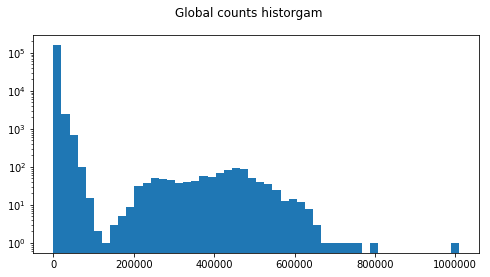

In [13]:
plt.figure(figsize=(8,4))
plt.suptitle("Global counts historgam")
_ = plt.hist(counts.GLOBAL_COUNT, log=True, bins=50)

### Cleanup
We have chosed to filter out the records where there was not enough mentions because the computation of the ratio would not be reliable. We've done this with the folowing quantile test:

In [14]:
q_minus = counts.GLOBAL_COUNT.quantile(0.05)
print(f"5% quantile: {q_minus:0.2f}")
counts = counts[(counts.GLOBAL_COUNT>q_minus)]

5% quantile: 4.00


# Worldwide ratio

Text(0, 0.5, 'Ratio [%]')

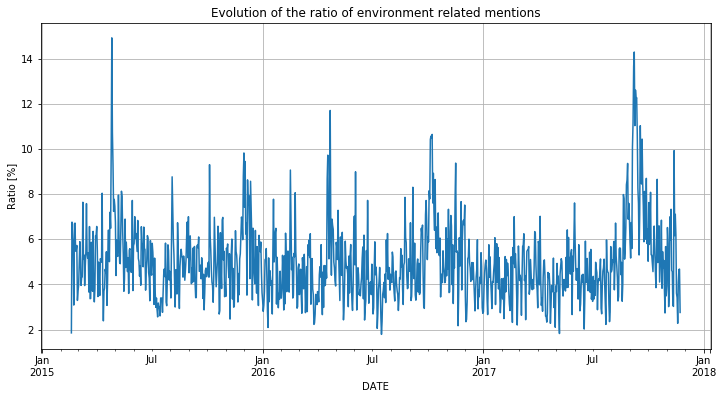

In [15]:
worldwide_ratio = counts.groupby(by=["DATE"]).sum().reset_index()
worldwide_ratio.assign(Ratio=worldwide_ratio.ENV_COUNT/worldwide_ratio.GLOBAL_COUNT)
ax = worldwide_ratio.plot.line(x="DATE", y=["Ratio"], figsize=(12, 6), legend=None, grid=True,
                 title="Evolution of the ratio of environment related mentions")
ax.set_ylabel("Ratio [%]")

In [17]:
worldwide_ratio[worldwide_ratio.Ratio>9.0].sort_values("Ratio", ascending=False)

,DATE,GLOBAL_COUNT,ENV_COUNT,Ratio
67,2015-04-26,461724,76043.0,14.914469
933,2017-09-08,640851,106569.0,14.287652
932,2017-09-07,667307,99510.0,13.651065
935,2017-09-10,378488,75885.0,12.602512
937,2017-09-12,703118,76427.0,12.266764
936,2017-09-11,616966,114922.0,12.227910
429,2016-04-22,721961,61939.0,11.699786
931,2017-09-06,702631,105144.0,11.158825
934,2017-09-09,402049,72347.0,11.027394
943,2017-09-18,623518,33572.0,11.024750


# Ratio by european countries
As we want display on a map the ratio for each european countries over the period of the dataset we need a single value for each countries. To do so, we used for each countries the median of all the daily ratios.

In [27]:
counts[counts.Country=="Russia"]

,GLOBAL_COUNT,ENV_COUNT,Country,Region,ISO,DATE,Ratio
119578,9850,4139.0,Russia,Europe,RU,2015-04-07,0.420203
119579,8350,3280.0,Russia,Europe,RU,2015-05-22,0.392814
119580,3278,1863.0,Russia,Europe,RU,2015-05-24,0.568334
119581,9045,2353.0,Russia,Europe,RU,2016-07-15,0.260144
119582,8896,2962.0,Russia,Europe,RU,2016-10-26,0.332959
119583,6950,2330.0,Russia,Europe,RU,2017-04-06,0.335252
119584,4796,2260.0,Russia,Europe,RU,2015-03-01,0.471226
119585,6934,2851.0,Russia,Europe,RU,2015-06-09,0.411162
119586,7814,2685.0,Russia,Europe,RU,2015-07-14,0.343614
119587,3932,2157.0,Russia,Europe,RU,2015-09-05,0.548576


In [18]:
europe_counts = counts[counts.Region=="Europe"].groupby(["ISO"]).median()
europe_counts.sort_values("GLOBAL_COUNT", ascending=False).head(10)

,GLOBAL_COUNT,ENV_COUNT,Ratio
ISO,,,
GB,15479.0,159.0,0.010918
RU,6102.0,2261.5,0.393527
IE,3967.5,63.0,0.015627
DE,1279.0,38.0,0.030540
FR,871.0,23.0,0.025649
IT,722.0,8.0,0.011751
CH,632.0,6.0,0.009403
UA,578.0,6.0,0.010886
GR,549.0,3.0,0.006623


Now we have all the data necessary to create the map

In [19]:
import json
import folium
import pygeoj
import branca

In [20]:
geo_json_data = pygeoj.load(DATA_PATH + "assets/europe.geojson")

In [21]:
results_map = folium.Map([49,15], tiles='cartodbpositron', zoom_start=4)

In [22]:
europe_counts = europe_counts.reset_index()

In [23]:
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 0.1)

In [24]:
def style_function(feature):
    value = europe_counts.loc[europe_counts['ISO']==feature['properties']['ISO2']].Ratio.values
    if(len(value)>0):
        value = value[0]
    else:
        value = None
    return {
        'fillOpacity': 0.6,
        'weight': 0,
        'fillColor': '#black' if value is None else colorscale(value)
    }

In [25]:
folium.GeoJson(
    geo_json_data,
    style_function=style_function
    ).add_to(results_map)

In [26]:
results_map.add_child(colorscale)